In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from os import path
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
df_train = train_data.copy()
df_test = test_data.copy()

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Understanding the Dataset

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
print(df_train.duplicated(['text', 'target']).sum())
print(df_train.duplicated(['text']).sum())

92
110


In [ ]:
df_train = df_train.drop_duplicates(["text", "target"])
df_train = df_train.drop(index=df_train[df_train.duplicated('text', keep=False)].index)

In [ ]:
len(df_train['keyword'].unique())

222

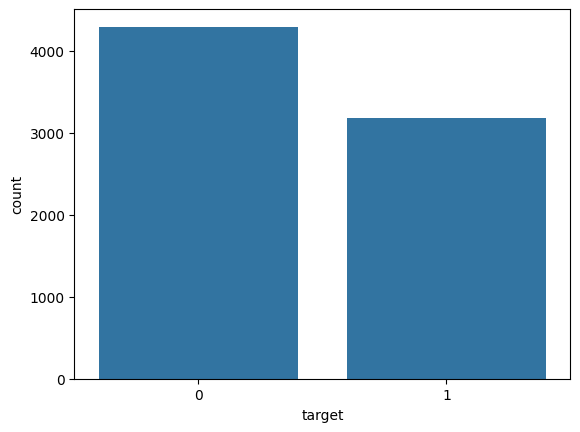

In [ ]:
sns.countplot(x="target", data=df_train);

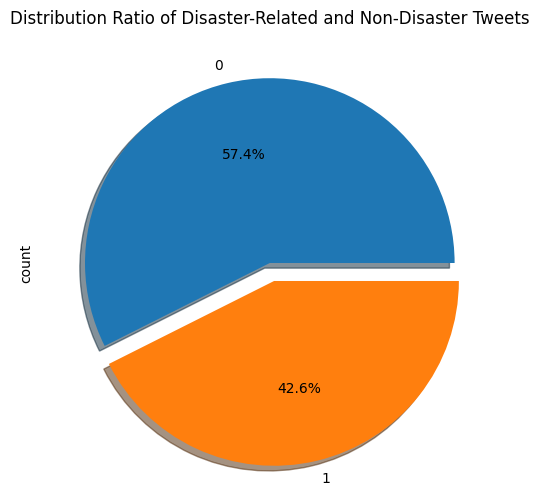

In [ ]:
df_train["target"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True);
plt.title("Distribution Ratio of Disaster-Related and Non-Disaster Tweets");

# Keyword

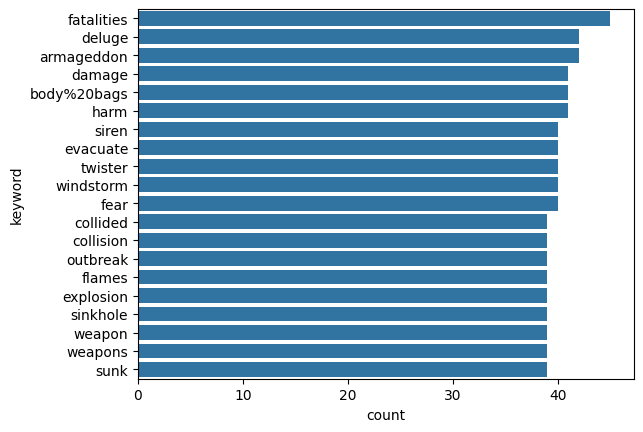

In [ ]:
sns.barplot(y=df_train['keyword'].value_counts()[:20].index,x=df_train['keyword'].value_counts()[:20], orient='h');

In [ ]:
df_train['keyword'].value_counts()[:20]

,count
keyword,
fatalities,45
deluge,42
armageddon,42
damage,41
body%20bags,41
harm,41
siren,40
evacuate,40
twister,40


In [ ]:
encoder = LabelEncoder()
df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,221,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,221,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,221,NaN,All residents asked to 'shelter in place' are ...,1
3,6,221,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,221,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Locations

In [ ]:
df_train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

<Axes: xlabel='count', ylabel='location'>

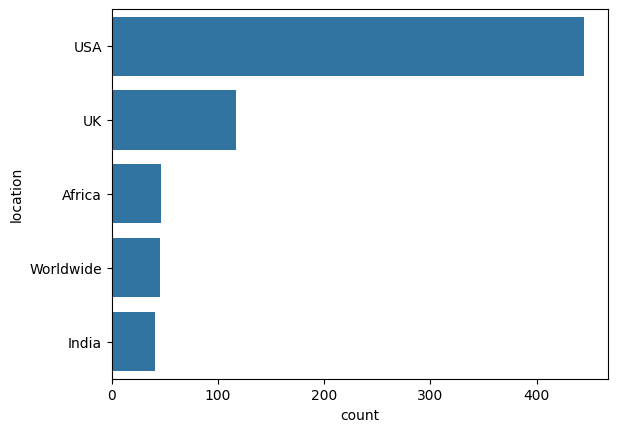

In [ ]:
sns.barplot(y=df_train['location'].value_counts()[:5].index,x=df_train['location'].value_counts()[:5], orient='h')

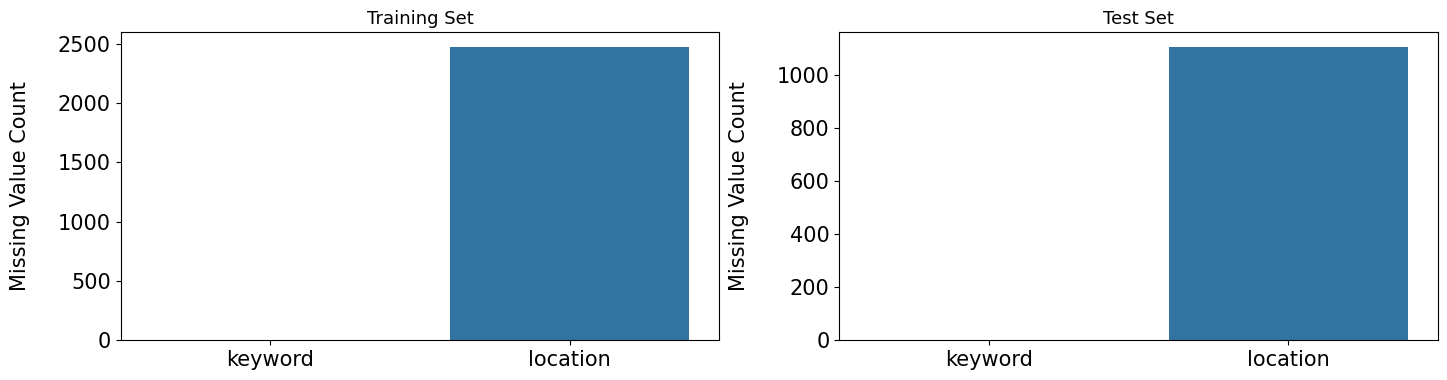

In [ ]:
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [ ]:
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df

,id,keyword,location,text,target
0,1,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,4,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,5,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,6,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,7,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
10743,10861,221,no_{col},EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10744,10865,221,no_{col},Storm in RI worse than last hurricane. My city...,NaN
10745,10868,221,no_{col},Green Line derailment in Chicago http://t.co/U...,NaN
10746,10874,221,no_{col},MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [ ]:
df = df.drop(['id'], axis=1)
#df_test = df_test.drop(['id', 'location'], axis=1)

# Mathematical Operations and Simple Feature Extraction

## a. Number of Letters/Characters

In [ ]:
x_df = df.copy()

In [ ]:
x_df["Number of Letters"] = x_df["text"].str.len()

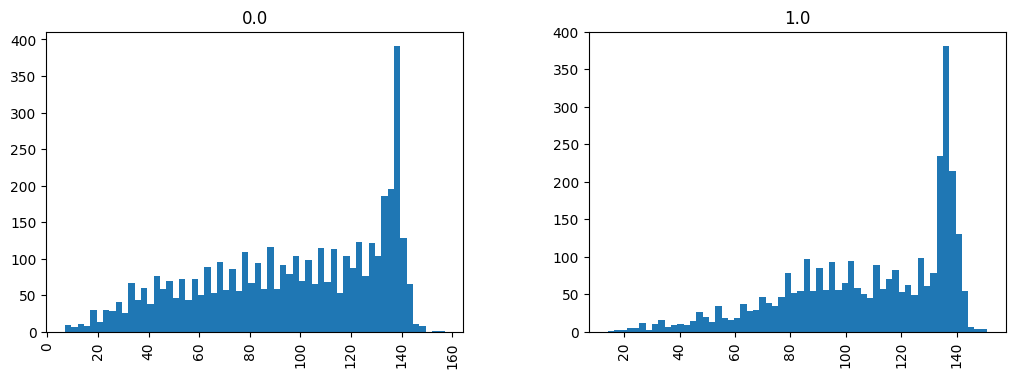

In [ ]:
x_df.hist(column='Number of Letters',by='target',bins=60,figsize=(12,4));

## b. Number of Words

In [ ]:
x_df["Number of Words"] = x_df["text"].apply(lambda x:len(str(x).split(" ")))
x_df.head()

,keyword,location,text,target,Number of Letters,Number of Words
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,13
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,7
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,22
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,9
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,17


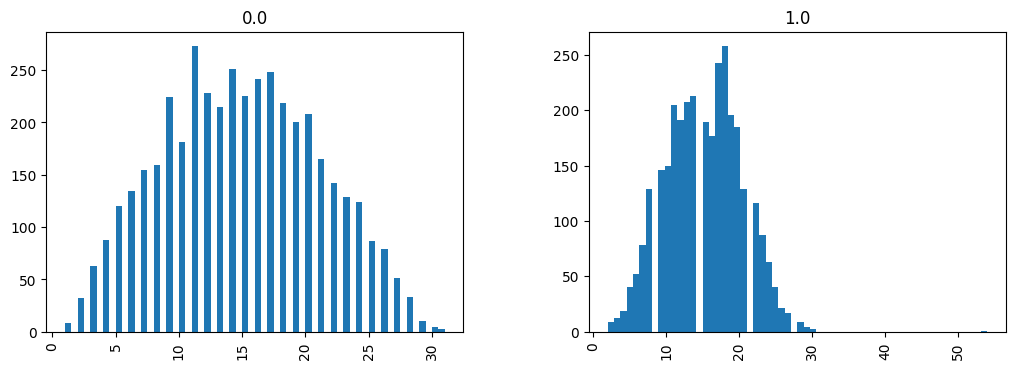

In [ ]:
x_df.hist(column='Number of Words',by='target',bins=60,figsize=(12,4));

## c. Detecting & Counting Numbers

In [ ]:
x_df["number_count"] = train_data["text"].apply(lambda x: len([x for x in x.split()
                                      if x.isdigit()]))

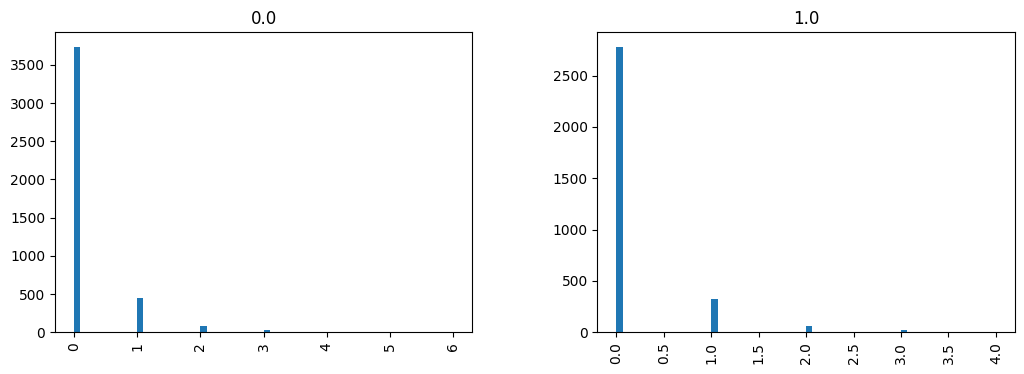

In [ ]:
x_df.hist(column='number_count',by='target',bins=60,figsize=(12,4));

In [ ]:
x_df.describe().T

,count,mean,std,min,25%,50%,75%,max
keyword,10748.0,110.442966,64.495341,0.0,55.0,110.0,167.0,221.0
target,7485.0,0.425919,0.494515,0.0,0.0,0.0,1.0,1.0
Number of Letters,10748.0,101.253163,33.874008,5.0,78.0,107.0,133.0,157.0
Number of Words,10748.0,14.923148,5.793816,1.0,11.0,15.0,19.0,54.0
number_count,7613.0,0.161960,0.468294,0.0,0.0,0.0,0.0,6.0


<Figure size 1200x800 with 0 Axes>

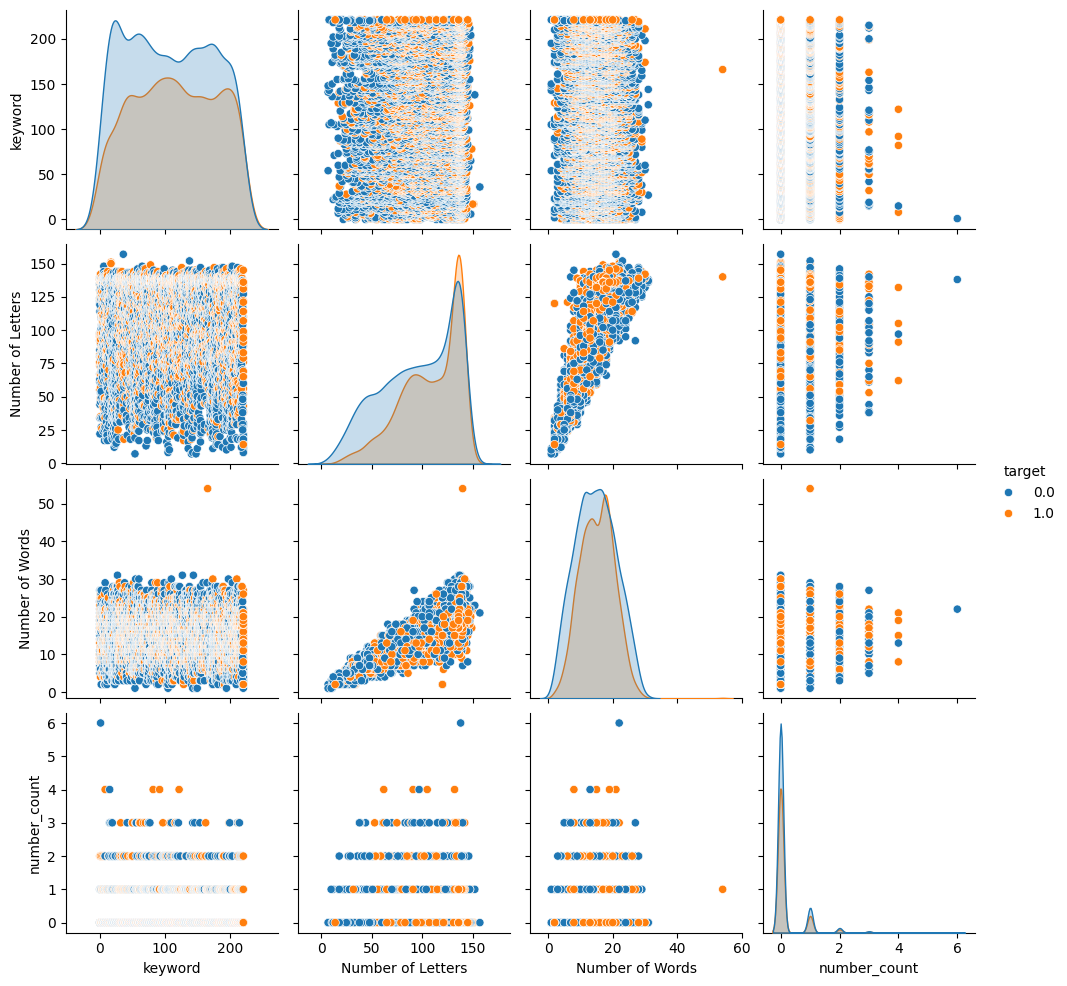

In [ ]:
plt.figure(figsize=(12,8));
fg = sns.pairplot(data=x_df, hue="target")
plt.show(fg)

## Text Preprocessing

In [ ]:
df = df.reset_index(drop=True)
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
5,221,no_{col},#RockyFire Update => California Hwy. 20 closed...,1.0
6,221,no_{col},#flood #disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I'm on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There's an emergency evacuation happening now ...,1.0
9,221,no_{col},I'm afraid that the tornado is coming to our a...,1.0


### URL Separation

In [ ]:
for i in range(len(df)):
    df["text"][i] = re.sub('(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#$\%\^\&\*_\-\=\+\\/\?\.\:\;\'\,]*)?', '', df["text"][i])

df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


### RT Separation

In [ ]:
for i in range(len(df)):
    df["text"][i] = re.sub('RT', '', df["text"][i])

df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


### Separation of Special Characters

In [ ]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])

df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask Canada,1.0
2,221,no_{col},All residents asked to shelter in place are ...,1.0
3,221,no_{col},people receive wildfires evacuation or...,1.0
4,221,no_{col},Just got sent this photo from Ruby Alaska as ...,1.0
5,221,no_{col},RockyFire Update California Hwy closed...,1.0
6,221,no_{col},flood disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I m on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There s an emergency evacuation happening now ...,1.0
9,221,no_{col},I m afraid that the tornado is coming to our a...,1.0


### Uppercase - Lowercase Conversion

In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,keyword,location,text,target
0,221,no_{col},our deeds are the reason of this earthquake ma...,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},all residents asked to shelter in place are be...,1.0
3,221,no_{col},people receive wildfires evacuation orders in ...,1.0
4,221,no_{col},just got sent this photo from ruby alaska as s...,1.0


### Stop Words

In [ ]:
import nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

from nltk.corpus import stopwords
sw = stopwords.words('english')
sw

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [ ]:
df.head(7000)

,keyword,location,text,target
0,221,no_{col},deeds reason earthquake may allah forgive us,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},residents asked shelter place notified officer...,1.0
3,221,no_{col},people receive wildfires evacuation orders cal...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...
6995,207,UK,pov video captures violent landing amsterdam a...,1.0
6996,207,no_{col},storm blitzes traverse city disrupts managemen...,1.0
6997,207,Oshawa/Toronto,one violent belligerent storm enjoying watchin...,1.0
6998,207,"Very SW CA, USA....Draenor",iateyourfood yikes poor pup weird violent storm,1.0


### Deletion of Infrequent Expressions

In [ ]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

,words,tf
0,amp,508
1,like,488
2,fire,362
3,get,337
4,new,330


In [ ]:
sil = least[least["tf"] < 50]
sil

,words,tf
369,wrecked,49
370,obliterated,49
371,report,49
372,obliterate,49
373,detonation,49
...,...,...
20111,jsyk,1
20112,thrillhho,1
20113,tyme,1
20114,smackdown,1


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

### Lemmitization

In [ ]:
df[:20]

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
5,221,no_{col},rockyfire update california hwy closed directi...,1.0
6,221,no_{col},flood disaster heavy rain cause flash flooding...,1.0
7,221,no_{col},top hill see fire wood,1.0
8,221,no_{col},emergency evacuation happening building across...,1.0
9,221,no_{col},afraid tornado coming area,1.0


## Term Frequency (TF)

In [ ]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [ ]:
tf1.head()

,words,tf
0,fire,517
1,amp,508
2,like,491
3,get,382
4,u,373


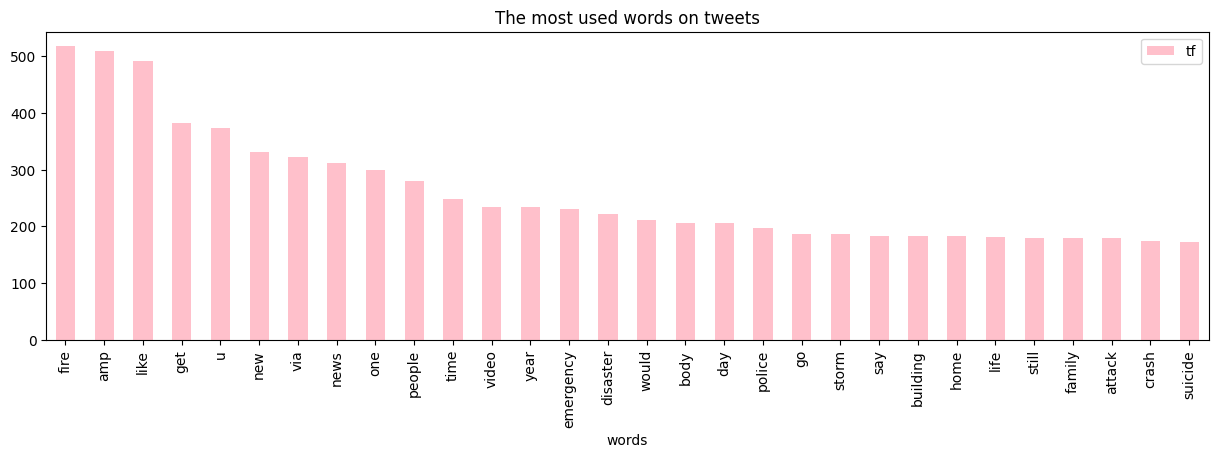

In [ ]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('The most used words on tweets');

In [ ]:
non_disaster_tweets_count = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(20)
non_disaster_tweets_count_df = pd.DataFrame(non_disaster_tweets_count, columns=["words", "freq"])
print("The 20 most frequently used words in tweets that are not related to disasters:")
non_disaster_tweets_count_df

The 20 most frequently used words in tweets that are not related to disasters:


,words,freq
0,like,254
1,amp,208
2,get,185
3,new,171
4,u,155
5,one,139
6,body,119
7,time,106
8,day,104
9,video,101


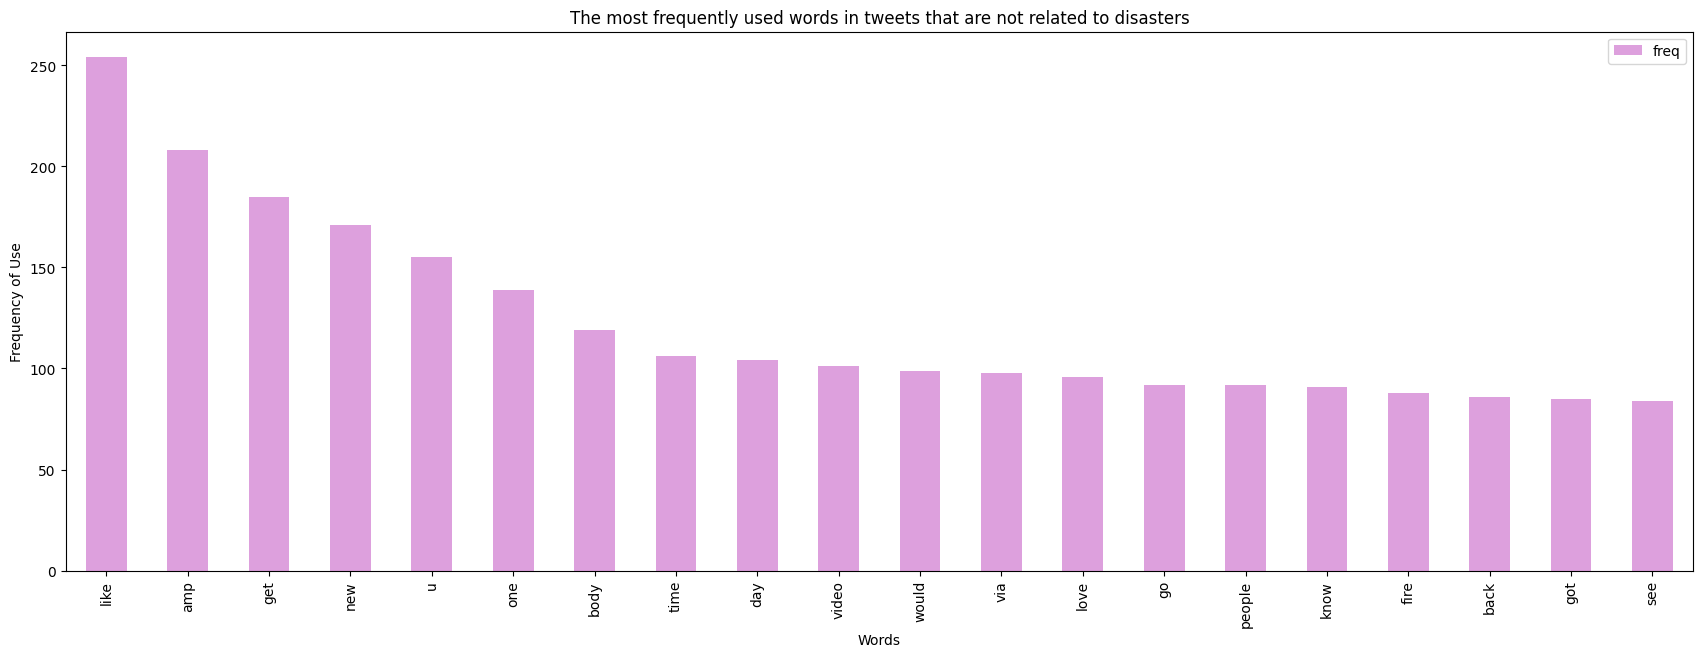

In [ ]:
non_disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum");
plt.title('The most frequently used words in tweets that are not related to disasters');
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

In [ ]:
disaster_tweets_count = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(20)
disaster_tweets_count_df = pd.DataFrame(disaster_tweets_count, columns=["words", "freq"])
print("The 20 most frequently used words in tweets related to disasters:")
disaster_tweets_count_df

The 20 most frequently used words in tweets related to disasters:


,words,freq
0,fire,262
1,news,149
2,amp,134
3,via,119
4,disaster,117
5,california,114
6,u,110
7,police,107
8,suicide,106
9,people,102


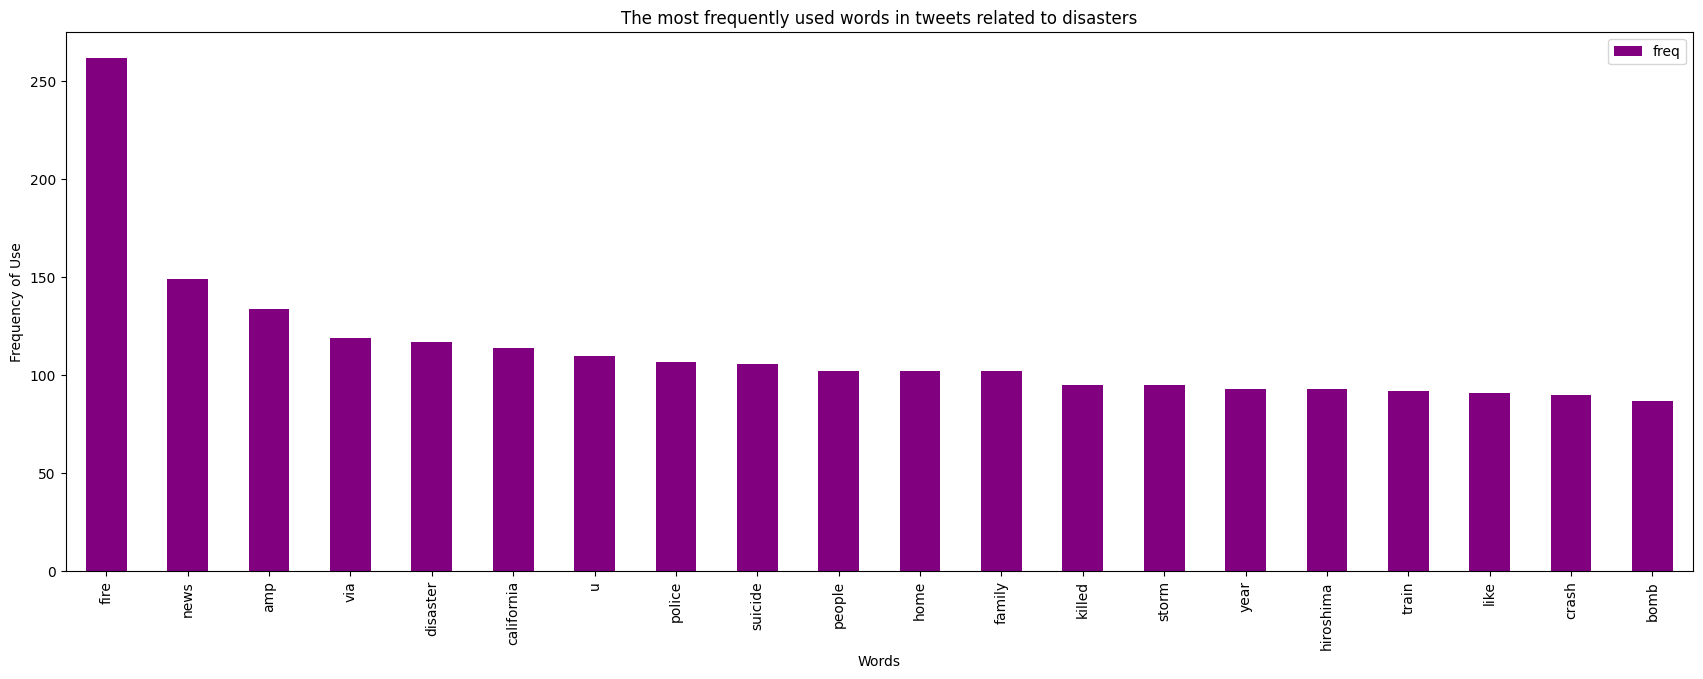

In [ ]:
disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple");
plt.title('The most frequently used words in tweets related to disasters');
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

## Word Cloud

In [ ]:
disaster_text = " ".join(i for i in (df[df['target']==1]['text']))

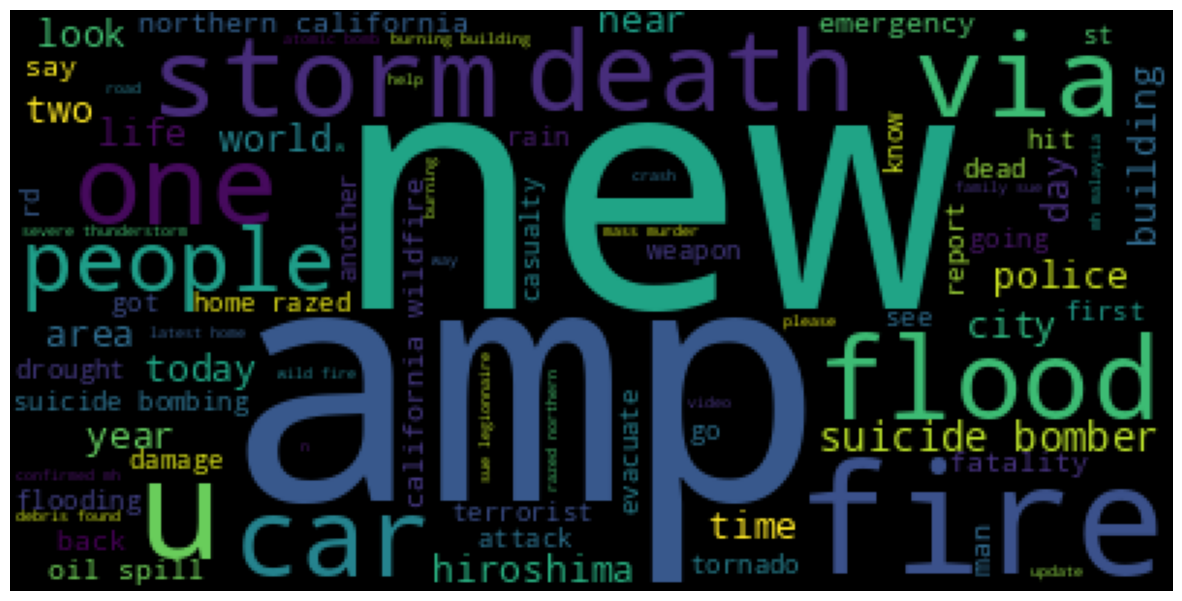

In [ ]:
wordcloud = WordCloud(background_color= "black").generate(disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
non_disaster_text = " ".join(i for i in (df[df['target']==0]['text']))

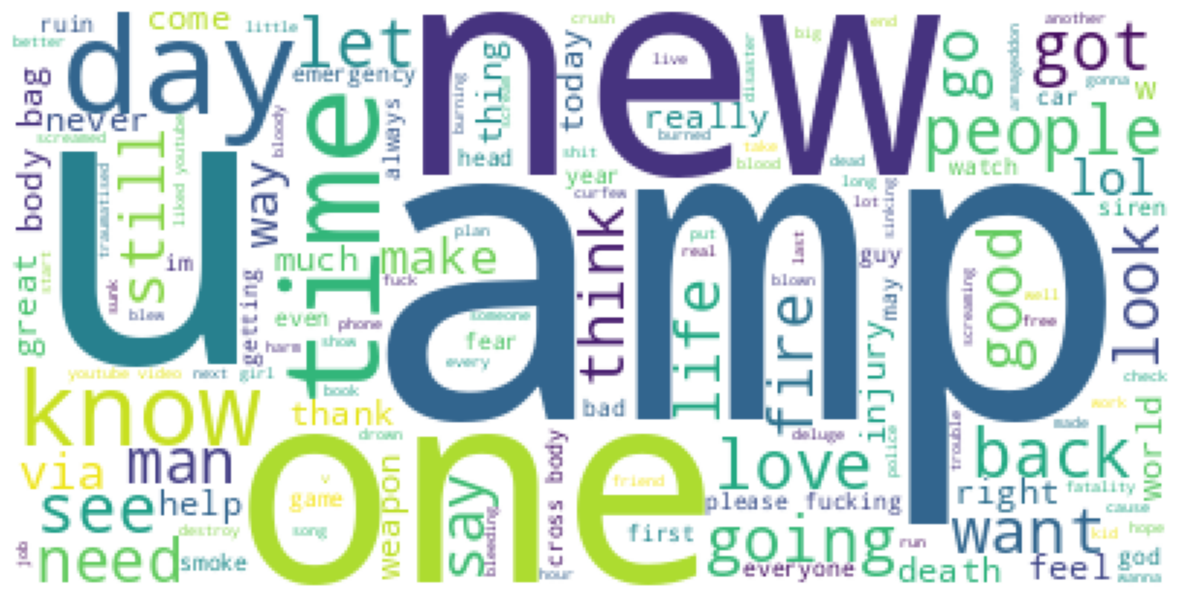

In [ ]:
wordcloud = WordCloud(background_color= "white").generate(non_disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Feature Engineering

* Count Vectors
* TF-IDF Vectors (words, characters, n-grams)
* Word Embeddings

TF(t) = (The frequency of occurrence of a term t in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents) / (Number of documents containing the term t)

## Train - Test

In [ ]:
y = df.target[:len(df_test)]
X = df.drop(["target","location"],axis=1)[:len(df_test)]

In [ ]:
X, y

(      keyword                                               text
 0         221         deed reason earthquake may allah forgive u
 1         221              forest fire near la ronge sask canada
 2         221  resident asked shelter place notified officer ...
 3         221  people receive wildfire evacuation order calif...
 4         221  got sent photo ruby alaska smoke wildfire pour...
 ...       ...                                                ...
 3258       95  store fire alarm went today work evacuate like...
 3259       95  louis sad cancel show everyone leave evacuate ...
 3260       95              evacuate student throw dungeon stupid
 3261       95  u also flew bomb site world war ii warning let...
 3262       95  mygc broken powerlines evacuate gold coast tra...
 
 [3263 rows x 2 columns],
 0       1.0
 1       1.0
 2       1.0
 3       1.0
 4       1.0
        ... 
 3258    1.0
 3259    0.0
 3260    0.0
 3261    1.0
 3262    1.0
 Name: target, Length: 3263, dtype: f

In [ ]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.30)
X_train.head()

,keyword,text
1556,45,deep sleep dream bout fall cliff wake struggli...
435,11,casper rmg bestcomedyvine whats cracking cuz
1829,53,ina buted girl crush
237,5,fun filled happy hour simmons bar camden hands...
2820,82,heat wave relentless f feel like humidity rele...


## Count Vectors

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])

CountVectorizer()

In [ ]:
x_train_count = vectorizer.fit_transform(X_train['text'])
x_test_count = vectorizer.transform(X_test['text'])

In [ ]:
vectorizer.get_feature_names_out()[:5]


array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [ ]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## TF- IDF

### Word Level TF-IDF

In [ ]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train['text'])
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test['text'])

In [ ]:
tf_idf_word_vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

### Ngram Level TF-IDF

In [ ]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train['text'])
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test['text'])

In [ ]:
tf_idf_ngram_vectorizer.get_feature_names_out()[:5]

array(['aa battery', 'aa battery swear', 'aa mgm', 'aa mgm grand',
       'aaaaaaallll even'], dtype=object)

### Characters level TF-IDF

In [ ]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train['text'])
x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test['text'])

In [ ]:
tf_idf_chars_vectorizer.get_feature_names_out()[:5]

array([' a', ' aa', ' ab', ' ac', ' ad'], dtype=object)

# Model Building

In [ ]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [ ]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [ ]:
def model_name(model, vector_name):
    model_name= model.__class__.__name__
    if vector_name == "c":
        return model_name+"_count"
    elif vector_name == "n":
        return model_name+"_ngram"
    elif vector_name == "w":
        return model_name+"_word"
    elif vector_name == "ch":
        return model_name+"_chars"
    else:
        return

In [ ]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [ ]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = pd.concat([all_performances, models], ignore_index=True)
    all_performances= all_performances.drop_duplicates()


In [ ]:
def model_performance(x_train_x, x_test_x, model, vector_name):

    x_model = fit_model(model, x_train_x, y_train)

    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)

    print(classification_report(y_test, y_pred, target_names=['non-disaster','disaster']))

## Logistic Regression

In [ ]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

non-disaster       0.82      0.89      0.85       609
    disaster       0.79      0.67      0.72       370

    accuracy                           0.81       979
   macro avg       0.80      0.78      0.79       979
weighted avg       0.81      0.81      0.80       979



In [ ]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.93      0.86       609
    disaster       0.85      0.63      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [ ]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

non-disaster       0.71      0.97      0.82       609
    disaster       0.88      0.34      0.49       370

    accuracy                           0.73       979
   macro avg       0.79      0.66      0.66       979
weighted avg       0.77      0.73      0.70       979



In [ ]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.89      0.84       609
    disaster       0.77      0.63      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979



## Naive Bayes

In [ ]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

non-disaster       0.83      0.84      0.84       609
    disaster       0.73      0.72      0.73       370

    accuracy                           0.80       979
   macro avg       0.78      0.78      0.78       979
weighted avg       0.79      0.80      0.80       979



In [ ]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

non-disaster       0.81      0.93      0.87       609
    disaster       0.85      0.64      0.73       370

    accuracy                           0.82       979
   macro avg       0.83      0.79      0.80       979
weighted avg       0.82      0.82      0.82       979



In [ ]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

non-disaster       0.73      0.96      0.83       609
    disaster       0.88      0.42      0.57       370

    accuracy                           0.76       979
   macro avg       0.81      0.69      0.70       979
weighted avg       0.79      0.76      0.73       979



In [ ]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

non-disaster       0.76      0.95      0.84       609
    disaster       0.85      0.51      0.64       370

    accuracy                           0.78       979
   macro avg       0.81      0.73      0.74       979
weighted avg       0.80      0.78      0.77       979



## Random Forests

In [ ]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.79      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.75      0.76       979
weighted avg       0.79      0.79      0.78       979



In [ ]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.90      0.85       609
    disaster       0.80      0.63      0.71       370

    accuracy                           0.80       979
   macro avg       0.80      0.77      0.78       979
weighted avg       0.80      0.80      0.80       979



In [ ]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.96      0.81       609
    disaster       0.84      0.33      0.48       370

    accuracy                           0.72       979
   macro avg       0.77      0.65      0.64       979
weighted avg       0.76      0.72      0.69       979



In [ ]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

non-disaster       0.77      0.92      0.84       609
    disaster       0.80      0.54      0.65       370

    accuracy                           0.78       979
   macro avg       0.78      0.73      0.74       979
weighted avg       0.78      0.78      0.76       979



## XGBoost

In [ ]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

              precision    recall  f1-score   support

non-disaster       0.81      0.91      0.86       609
    disaster       0.82      0.65      0.72       370

    accuracy                           0.81       979
   macro avg       0.81      0.78      0.79       979
weighted avg       0.81      0.81      0.81       979



In [ ]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

              precision    recall  f1-score   support

non-disaster       0.79      0.91      0.85       609
    disaster       0.80      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.80      0.76      0.77       979
weighted avg       0.80      0.79      0.79       979



In [ ]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

              precision    recall  f1-score   support

non-disaster       0.67      0.96      0.79       609
    disaster       0.79      0.24      0.37       370

    accuracy                           0.69       979
   macro avg       0.73      0.60      0.58       979
weighted avg       0.72      0.69      0.63       979



In [ ]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")



              precision    recall  f1-score   support

non-disaster       0.78      0.84      0.81       609
    disaster       0.70      0.60      0.65       370

    accuracy                           0.75       979
   macro avg       0.74      0.72      0.73       979
weighted avg       0.75      0.75      0.75       979



## SVC

In [ ]:
svc = svm.SVC()
model_performance(x_train_count, x_test_count, svc, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.94      0.86       609
    disaster       0.86      0.59      0.70       370

    accuracy                           0.81       979
   macro avg       0.83      0.77      0.78       979
weighted avg       0.82      0.81      0.80       979



In [ ]:
svc = svm.SVC()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, svc, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.94      0.86       609
    disaster       0.86      0.61      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [ ]:
svc = svm.SVC()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, svc, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.97      0.82       609
    disaster       0.87      0.33      0.48       370

    accuracy                           0.73       979
   macro avg       0.79      0.65      0.65       979
weighted avg       0.77      0.73      0.69       979



In [ ]:
svc = svm.SVC()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, svc, "ch")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.78      0.61      0.68       370

    accuracy                           0.79       979
   macro avg       0.79      0.75      0.76       979
weighted avg       0.79      0.79      0.78       979



# Performance Evaluation

In [ ]:
def display_all_confusion_matrix():
    f, ax = plt.subplots(6, 4, figsize=(20,40), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust()


    f.colorbar(disp.im_)
    plt.show()

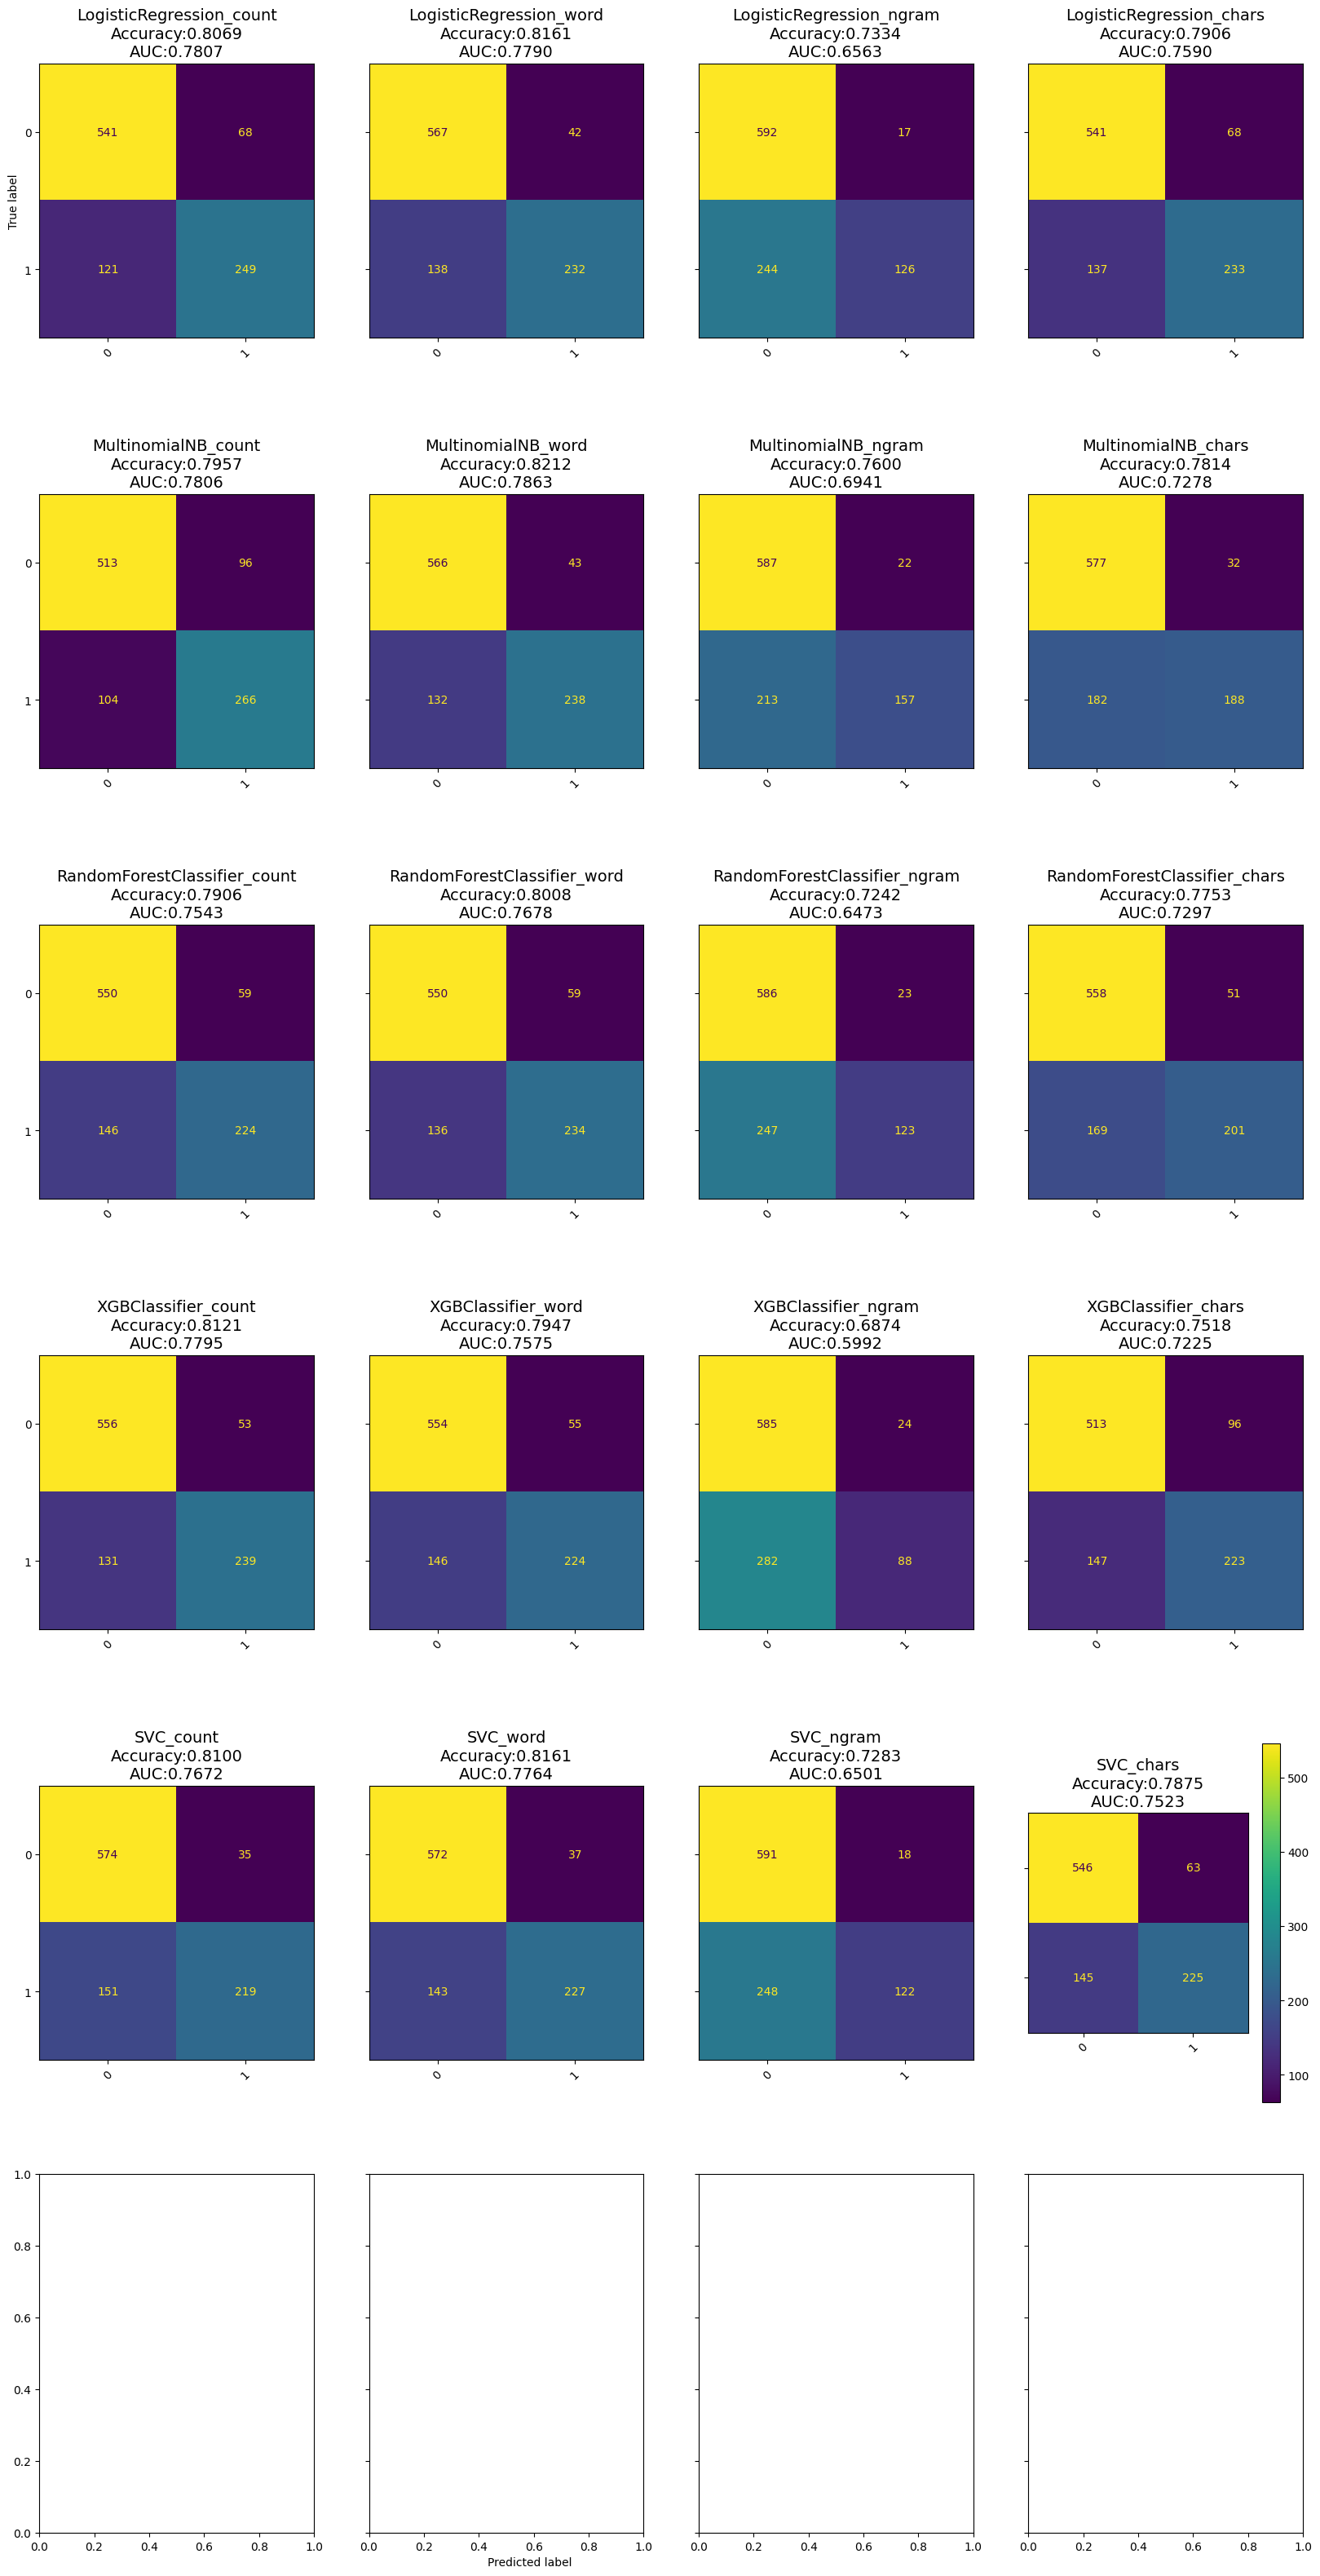

In [ ]:
display_all_confusion_matrix()

In [ ]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.795710,0.734807,0.718919,0.726776,0.780642
0,LogisticRegression_count,0.975919,0.806946,0.785489,0.672973,0.724891,0.780657
12,XGBClassifier_count,0.855954,0.812053,0.818493,0.645946,0.722054,0.779459
1,LogisticRegression_word,0.894046,0.816139,0.846715,0.627027,0.720497,0.779031
17,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
9,RandomForestClassifier_word,0.991681,0.800817,0.798635,0.632432,0.705882,0.767776
16,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210
3,LogisticRegression_chars,0.863398,0.790603,0.774086,0.629730,0.694486,0.759036
13,XGBClassifier_word,0.893170,0.794688,0.802867,0.605405,0.690293,0.757547


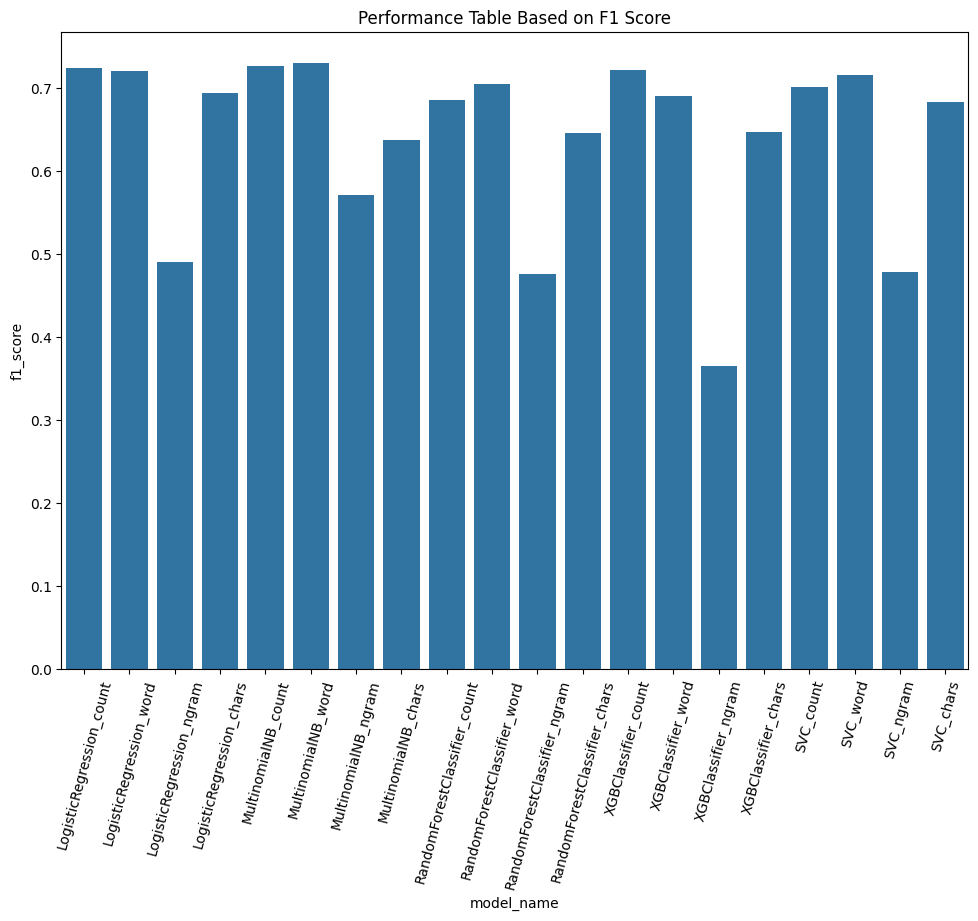

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('Performance Table Based on F1 Score')

## Hyperparameter Tuning

## Naive Bayes

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'alpha': [11.25,11.5,11.75],  # smoothing parameter
    'fit_prior': [True, False],  # whether to learn class prior probabilities or use uniform priors
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],  # prior probabilities of the classes
}

In [ ]:
classifier = naive_bayes.MultinomialNB()

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

### Count Vector

In [ ]:
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [ ]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.75, 'class_prior': None, 'fit_prior': True}
Best Score:  0.7859006103881148


In [ ]:
best_classifier = grid_search.best_estimator_
accuracy = best_classifier.score(x_test_count, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8161389172625128


### Word Level TF-IDF

In [ ]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [ ]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.25, 'class_prior': None, 'fit_prior': False}
Best Score:  0.768375945333794


## SVC (Word Level TF-IDF)

In [ ]:
param_grid = {
    'C': [0.5, 1.0, 1.5],  # regularization parameter
    'kernel': ['linear', 'rbf'],  # kernel type
    'gamma': ['scale', 'auto']  # kernel coefficient for 'rbf'
}

In [ ]:
classifier = SVC()

In [ ]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

In [ ]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...................C=0.5, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ...................C=0.5, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1.0, 1.5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [ ]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score:  0.7775874313793235


## Logistic Regression (Count Vector)

In [ ]:
param_grid = {
    'C': [0.25,0.3,0.35],  # inverse regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
    'solver': ['liblinear', 'saga']  # optimization algorithm
}

In [ ]:
classifier = linear_model.LogisticRegression()

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.25, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solv

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.3, 0.35], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [ ]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.7867806825597911


# Best Performing Model

In [ ]:
best_classifier = grid_search.best_estimator_

In [ ]:
best_classifier

LogisticRegression(C=0.25, solver='saga')

In [ ]:
model_performance(x_train_count, x_test_count, best_classifier, "c_tuned")

              precision    recall  f1-score   support

non-disaster       0.81      0.92      0.86       609
    disaster       0.83      0.66      0.73       370

    accuracy                           0.82       979
   macro avg       0.82      0.79      0.80       979
weighted avg       0.82      0.82      0.81       979



In [ ]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
20,None,0.929072,0.818182,0.826531,0.656757,0.731928,0.786506
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.795710,0.734807,0.718919,0.726776,0.780642
0,LogisticRegression_count,0.975919,0.806946,0.785489,0.672973,0.724891,0.780657
12,XGBClassifier_count,0.855954,0.812053,0.818493,0.645946,0.722054,0.779459
1,LogisticRegression_word,0.894046,0.816139,0.846715,0.627027,0.720497,0.779031
17,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
9,RandomForestClassifier_word,0.991681,0.800817,0.798635,0.632432,0.705882,0.767776
16,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210
3,LogisticRegression_chars,0.863398,0.790603,0.774086,0.629730,0.694486,0.759036


In [ ]:
df

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
...,...,...,...,...
10743,221,no_{col},eahquake safety los angeles safety fastener xrwn,NaN
10744,221,no_{col},storm ri worse last hurricane city amp others ...,NaN
10745,221,no_{col},green line derailment chicago,NaN
10746,221,no_{col},meg issue hazardous weather outlook hwo,NaN


In [ ]:
X_pred = df[len(df_train):].drop("target",axis=1)
X_pred["text"]

,text
7485,happened terrible car crash
7486,heard earthquake different city stay safe ever...
7487,forest fire spot pond goose fleeing across str...
7488,apocalypse lighting spokane wildfire
7489,typhoon soudelor kill china taiwan
...,...
10743,eahquake safety los angeles safety fastener xrwn
10744,storm ri worse last hurricane city amp others ...
10745,green line derailment chicago
10746,meg issue hazardous weather outlook hwo


In [ ]:
X_train['text']

,text
1556,deep sleep dream bout fall cliff wake struggli...
435,casper rmg bestcomedyvine whats cracking cuz
1829,ina buted girl crush
237,fun filled happy hour simmons bar camden hands...
2820,heat wave relentless f feel like humidity rele...
...,...
1095,st august turkish jet bombed village zergele q...
1130,cryptic word guided pilot hiroshima bombing mi...
1294,kanger coil burning fast via r vaping
860,blood


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['text'])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20148 stored elements and shape (2284, 6948)>

In [ ]:
X_pred_count = vectorizer.transform(X_pred["text"])

In [ ]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [ ]:
X_pred_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_pred_count.shape

(3263, 6948)

In [ ]:
x_train_count.shape

(2284, 6948)

In [ ]:
y_pred = best_classifier.predict(X_pred_count)

In [ ]:
sample_submission["target"].shape

(3263,)

In [ ]:
 X_pred["text"].shape

(3263,)

In [ ]:
y_pred.shape

(3263,)

In [ ]:
data = {'tweet': X_pred["text"], 'location': X_pred['location'] , 'predicted_label': y_pred}
predicted_data = pd.DataFrame(data).reset_index(drop=True)

In [ ]:
predicted_data['actual_label'] = sample_submission["target"].reset_index(drop=True)

In [ ]:
predicted_data

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,heard earthquake different city stay safe ever...,no_{col},1.0,0
2,forest fire spot pond goose fleeing across str...,no_{col},1.0,0
3,apocalypse lighting spokane wildfire,no_{col},1.0,0
4,typhoon soudelor kill china taiwan,no_{col},0.0,0
...,...,...,...,...
3258,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
3259,storm ri worse last hurricane city amp others ...,no_{col},1.0,0
3260,green line derailment chicago,no_{col},1.0,0
3261,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [ ]:
sample_submission["target"].unique()

array([0])

In [ ]:
right_predictions = predicted_data[(predicted_data["predicted_label"] == predicted_data["actual_label"])]
right_predictions = right_predictions.reset_index(drop=True)
right_predictions

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,typhoon soudelor kill china taiwan,no_{col},0.0,0
2,probably still show life arsenal yesterday eh eh,no_{col},0.0,0
3,hey,no_{col},0.0,0
4,nice hat,no_{col},0.0,0
...,...,...,...,...
2399,see yr old pkk suicide bomber detonated bomb t...,no_{col},0.0,0
2400,conference attendee blue line airport derailed...,no_{col},0.0,0
2401,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
2402,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [ ]:
accuracy = len(right_predictions)*100/len(predicted_data)
accuracy

73.67453263867607

In [343]:
import joblib

# Save best model and vectorizer
joblib.dump(best_classifier, "best_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


#Testing on New Dataset

In [339]:
from google.colab import files
uploaded = files.upload()


Saving tweets.csv to tweets.csv


In [353]:

df_new = pd.read_csv("tweets.csv")
df_new.head()


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [352]:

X_new = df_new['text']

# Transforming using saved vectorizer
X_new_vec = vectorizer.transform(X_new)

y_pred_new = best_classifier.predict(X_new_vec)

df_new['prediction'] = y_pred_new
df_new.head()


,id,keyword,location,text,target,predicted,prediction
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,0.0,0.0
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,0.0,0.0
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,0.0,0.0
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,0.0,0.0
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,0.0,0.0


 **Model Performance on New Dataset**
 Accuracy:  77.95%
 Precision: 0.43
 Recall:    0.54
 F1-Score:  0.47
 ROC-AUC:   0.69

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.89      0.84      0.86      9256
    Disaster       0.43      0.54      0.47      2114

    accuracy                           0.78     11370
   macro avg       0.66      0.69      0.67     11370
weighted avg       0.80      0.78      0.79     11370



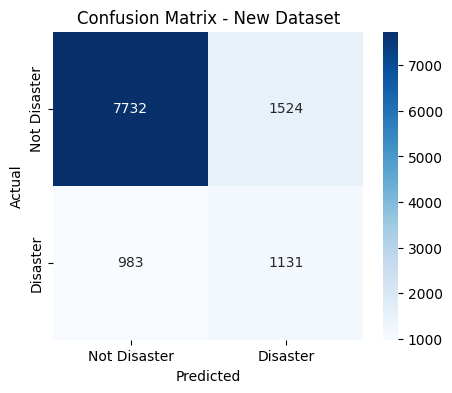

In [355]:


#  Ensuring 'text' column exists
if 'text' not in df_new.columns:
    raise ValueError("Column 'text' not found in dataset!")

# Transforming text using vectorizer
X_new_vec = vectorizer.transform(df_new['text'])

y_pred_new = model.predict(X_new_vec)
df_new['predicted'] = y_pred_new

#  Evaluating only if true labels exist
if 'target' in df_new.columns:
    y_true = df_new['target']

    acc = accuracy_score(y_true, y_pred_new)
    prec = precision_score(y_true, y_pred_new)
    rec = recall_score(y_true, y_pred_new)
    f1 = f1_score(y_true, y_pred_new)
    auc = roc_auc_score(y_true, y_pred_new)
    print(" **Model Performance on New Dataset**")
    print(f" Accuracy:  {acc*100:.2f}%")
    print(f" Precision: {prec:.2f}")
    print(f" Recall:    {rec:.2f}")
    print(f" F1-Score:  {f1:.2f}")
    print(f" ROC-AUC:   {auc:.2f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred_new, target_names=['Non-Disaster','Disaster']))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred_new),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Disaster','Disaster'],
                yticklabels=['Not Disaster','Disaster'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - New Dataset")
    plt.show()

else:
    print("No 'target' column found — skipping metric evaluation.")
    print(" Showing first few predictions instead:")
    print(df_new[['text','predicted']].head())


In [ ]:
!pip install streamlit
!pip install pyngrok


In [ ]:
from pyngrok import ngrok


In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.0 MB/s eta 0:00:00


In [ ]:
!ngrok authtoken 34kNF8Rq5bE88ddtryWhGJkgxd4_3FM573uESzoFX2ARv1LyW

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!streamlit run app.py &>/dev/null&
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("🚀 Streamlit app running at:", public_url)


🚀 Streamlit app running at: NgrokTunnel: "https://raisable-unobligatory-deshawn.ngrok-free.dev" -> "http://localhost:8501"
